In [1]:
# Core libraries
import os
import glob
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from time import time
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# HuggingFace
from transformers import AutoImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer

# Scikit-learn for metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.benchmark = True  # Optimizes performance for constant image sizes

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

2025-06-27 05:56:02.283391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751003762.486611      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751003762.543969      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
GPU: Tesla P100-PCIE-16GB


Class mappings:
bags: 0
shoes: 1
laptop: 2
shirts: 3
watches: 4
glasses: 5
headphones: 6

Dataset Statistics:
Training images: 29172
Validation images: 6252
Test images: 6253
Total images: 41677


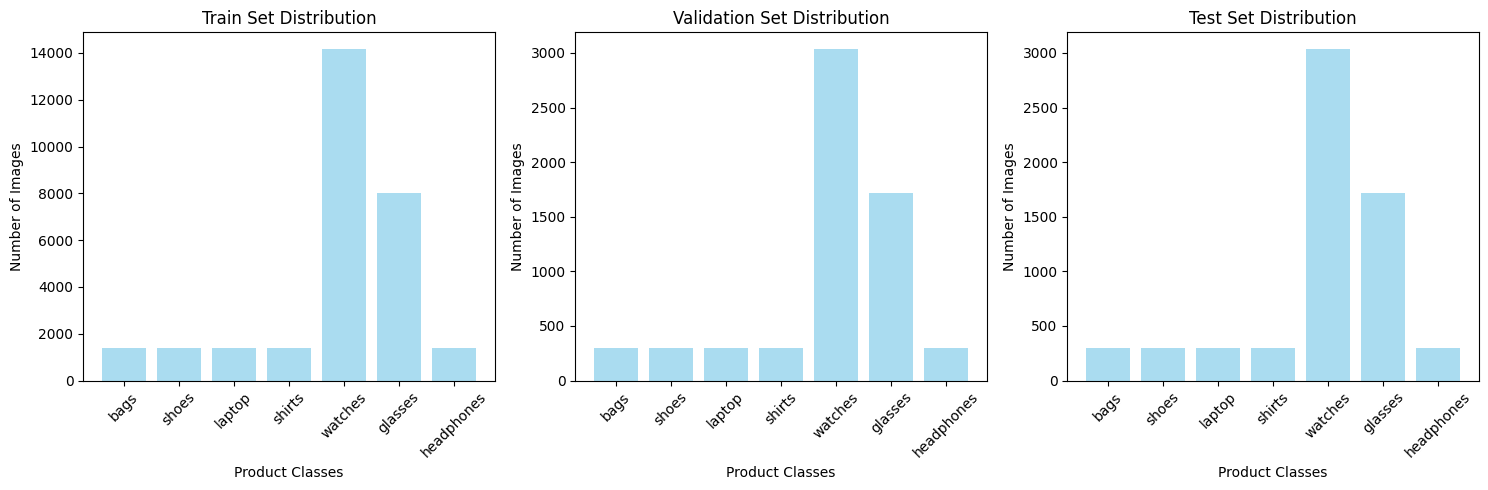

In [4]:
# Define class names and data paths
CLASS_NAMES = ['bags', 'shoes', 'laptop', 'shirts', 'watches', 'glasses', 'headphones']
DATA_DIR = '/kaggle/input/split-dataset-upload/split'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')
    
# Create label to index mapping
label_to_idx = {label: idx for idx, label in enumerate(CLASS_NAMES)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

print("Class mappings:")
for label, idx in label_to_idx.items():
    print(f"{label}: {idx}")

# Count images in each split
def count_images(data_dir):
    counts = {}
    total = 0
    for class_name in CLASS_NAMES:
        class_path = os.path.join(data_dir, class_name)
        if os.path.exists(class_path):
            count = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            counts[class_name] = count
            total += count
        else:
            counts[class_name] = 0
    return counts, total

train_counts, train_total = count_images(TRAIN_DIR)
val_counts, val_total = count_images(VAL_DIR)
test_counts, test_total = count_images(TEST_DIR)

print(f"\nDataset Statistics:")
print(f"Training images: {train_total}")
print(f"Validation images: {val_total}")
print(f"Test images: {test_total}")
print(f"Total images: {train_total + val_total + test_total}")

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
splits = ['Train', 'Validation', 'Test']
counts_list = [train_counts, val_counts, test_counts]

for idx, (split, counts) in enumerate(zip(splits, counts_list)):
    classes = list(counts.keys())
    values = list(counts.values())
    
    axes[idx].bar(classes, values, color='skyblue', alpha=0.7)
    axes[idx].set_title(f'{split} Set Distribution')
    axes[idx].set_xlabel('Product Classes')
    axes[idx].set_ylabel('Number of Images')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [5]:
# Check actual files in test directory
print("\n📁 Checking test directory structure:")
for class_name in CLASS_NAMES:
    test_class_path = os.path.join(TEST_DIR, class_name)
    if os.path.exists(test_class_path):
        files = [f for f in os.listdir(test_class_path) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        print(f"  {class_name}: {len(files)} files")
        if len(files) == 0:
            print(f"    ❌ No valid image files found!")
    else:
        print(f"  {class_name}: ❌ Directory doesn't exist!")


📁 Checking test directory structure:
  bags: 300 files
  shoes: 300 files
  laptop: 299 files
  shirts: 300 files
  watches: 3037 files
  glasses: 1717 files
  headphones: 300 files


In [6]:
class ProductDataset(Dataset):
    """
    Custom PyTorch Dataset for loading product images
    
    This class handles:
    - Loading images from directory structure
    - Applying image transformations
    - Converting class names to numerical labels
    """
    
    def __init__(self, data_dir, class_names, processor, transform=None):
        """
        Args:
            data_dir (str): Path to data directory containing class folders
            class_names (list): List of class names
            processor: HuggingFace image processor
            transform: Optional additional transforms
        """
        self.data_dir = data_dir
        self.class_names = class_names
        self.processor = processor
        self.transform = transform
        self.label_to_idx = {label: idx for idx, label in enumerate(class_names)}
        
        # Load all image paths and labels
        self.image_paths = []
        self.labels = []
        
        for class_name in class_names:
            class_dir = os.path.join(data_dir, class_name)
            if os.path.exists(class_dir):
                # Get all image files in the class directory
                image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
                for ext in image_extensions:
                    pattern = os.path.join(class_dir, ext)
                    class_images = glob.glob(pattern)
                    self.image_paths.extend(class_images)
                    self.labels.extend([self.label_to_idx[class_name]] * len(class_images))
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        # Apply additional transforms if provided
        if self.transform:
            image = self.transform(image)
        
        # Process image using HuggingFace processor
        # This handles resizing, normalization, and tensor conversion
        inputs = self.processor(image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0)  # Remove batch dimension
        
        label = self.labels[idx]
        
        return {
            'pixel_values': pixel_values,
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Test the dataset
print("Testing dataset loading...")
# Initialize image processor (we'll use ViT-base processor)
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

# Create a small test dataset to verify everything works
test_dataset = ProductDataset(TRAIN_DIR, CLASS_NAMES, processor)
print(f"Dataset loaded successfully! Total samples: {len(test_dataset)}")

# Test loading a single sample
sample = test_dataset[0]
print(f"Sample pixel values shape: {sample['pixel_values'].shape}")
print(f"Sample label: {sample['labels'].item()} ({CLASS_NAMES[sample['labels'].item()]})")

Testing dataset loading...


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Dataset loaded successfully! Total samples: 29172
Sample pixel values shape: torch.Size([3, 224, 224])
Sample label: 0 (bags)


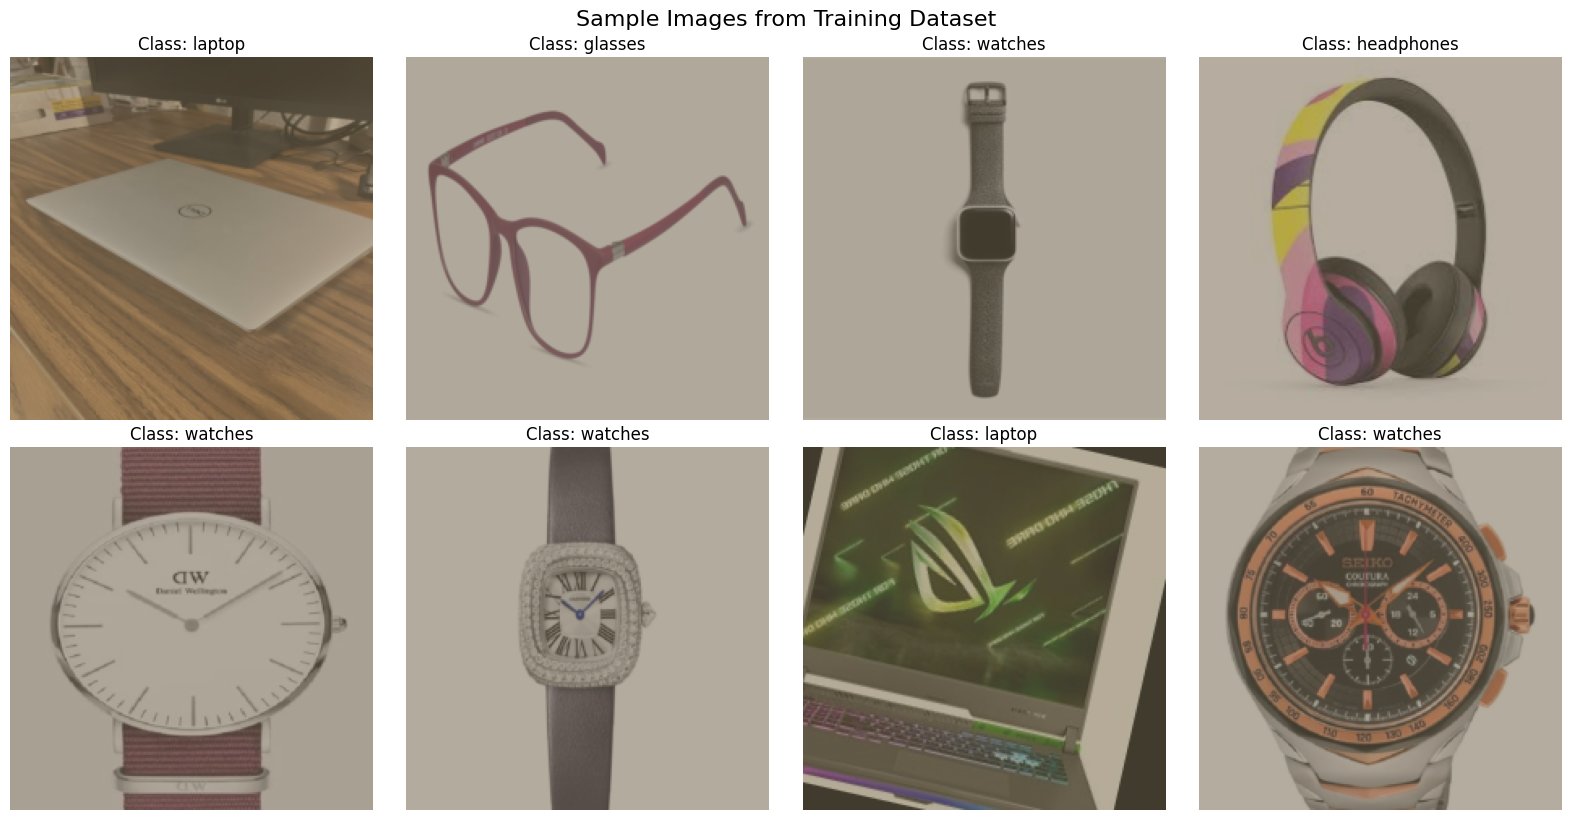

In [7]:
def visualize_samples(dataset, num_samples=8):
    """Visualize sample images from the dataset"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        sample = dataset[idx]
        
        # Convert tensor back to PIL Image for visualization
        # Denormalize the image (reverse the normalization applied by processor)
        pixel_values = sample['pixel_values'].numpy()
        pixel_values = np.transpose(pixel_values, (1, 2, 0))
        
        # The ViT processor normalizes with ImageNet stats, so we reverse it
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        pixel_values = pixel_values * std + mean
        pixel_values = np.clip(pixel_values, 0, 1)
        
        label_idx = sample['labels'].item()
        class_name = CLASS_NAMES[label_idx]
        
        axes[i].imshow(pixel_values)
        axes[i].set_title(f'Class: {class_name}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Sample Images from Training Dataset', y=1.02, fontsize=16)
    plt.show()

# Visualize samples
visualize_samples(test_dataset)

In [8]:
# Model configuration
MODEL_NAME = 'google/vit-base-patch16-224-in21k'
NUM_CLASSES = len(CLASS_NAMES)
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
NUM_EPOCHS = 15

print(f"Model: {MODEL_NAME}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of epochs: {NUM_EPOCHS}")

# Initialize the pretrained model
model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True  # This allows us to use a different number of classes
)

# Move model to device
model = model.to(device)

print(f"\nModel loaded and moved to {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model: google/vit-base-patch16-224-in21k
Number of classes: 7
Batch size: 64
Learning rate: 0.0001
Number of epochs: 15


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model loaded and moved to cuda
Model parameters: 85,804,039
Trainable parameters: 85,804,039


In [9]:
# Create datasets for all splits
train_dataset = ProductDataset(TRAIN_DIR, CLASS_NAMES, processor)
val_dataset = ProductDataset(VAL_DIR, CLASS_NAMES, processor)
test_dataset = ProductDataset(TEST_DIR, CLASS_NAMES, processor)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=16,  # Adjust based on your system
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=16,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=16,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nData loaders created:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training samples: 29172
Validation samples: 6252
Test samples: 6253

Data loaders created:
Training batches: 456
Validation batches: 98
Test batches: 98


In [10]:
# Loss Function: CrossEntropyLoss
# CrossEntropyLoss combines softmax activation and negative log-likelihood loss
# It's ideal for multi-class classification problems where each sample belongs to exactly one class
# The loss increases when the predicted probability for the correct class decreases
criterion = nn.CrossEntropyLoss().to(device)

# Optimizer: Adam
# Adam (Adaptive Moment Estimation) is an efficient optimization algorithm that:
# - Adapts learning rates for each parameter individually
# - Uses momentum (moving averages of gradients) 
# - Generally converges faster than SGD and handles sparse gradients well
# - Good default choice for most deep learning problems
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Optional: Learning rate scheduler
# Reduces learning rate when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3, 
    verbose=True
)

print("Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam (lr={LEARNING_RATE})")
print("Scheduler: ReduceLROnPlateau")

Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.0001)
Scheduler: ReduceLROnPlateau


In [12]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model = model.to(device)
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, batch in enumerate(train_loader):
        # Move data to device
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(pixel_values=pixel_values)
        loss = criterion(outputs.logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        # Print progress every 50 batches
        if (batch_idx + 1) % 50 == 0:
            print(f'Batch {batch_idx + 1}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}, '
                  f'Acc: {100.0 * correct_predictions / total_samples:.2f}%')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct_predictions / total_samples
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Validate the model for one epoch"""
    model = model.to(device)
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch in val_loader:
            # Move data to device
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(pixel_values=pixel_values)
            loss = criterion(outputs.logits, labels)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.logits.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100.0 * correct_predictions / total_samples
    
    return epoch_loss, epoch_acc

In [13]:
# Initialize tracking lists
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Best model tracking
best_val_acc = 0.0
best_model_state = None

# Display device information before training
print(f"🚀 Starting training on device: {device}")
if torch.cuda.is_available():
    print(f"📱 GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️  Using CPU - training will be slower")
print("=" * 60)


for epoch in range(NUM_EPOCHS):
    start = time()
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 30)
    
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate scheduler
    scheduler.step(val_loss)
    
    # Save metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        print(f"★ New best validation accuracy: {val_acc:.2f}%")
    
    # Print epoch summary
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {current_lr:.2e}")
    print("Epoch took:", time() - start, "seconds")
    
    # Display GPU memory usage if available
    if torch.cuda.is_available():
        memory_used = torch.cuda.memory_allocated(0) / 1024**3
        memory_total = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"🔥 GPU Memory: {memory_used:.1f}/{memory_total:.1f} GB ({memory_used/memory_total*100:.1f}%)")

print("\n" + "=" * 60)
print(f"Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model weights")

🚀 Starting training on device: cuda
📱 GPU Name: Tesla P100-PCIE-16GB
💾 GPU Memory: 15.9 GB

Epoch 1/15
------------------------------
Batch 50/456, Loss: 0.2325, Acc: 90.56%
Batch 100/456, Loss: 0.1038, Acc: 94.97%
Batch 150/456, Loss: 0.0644, Acc: 96.52%
Batch 200/456, Loss: 0.0812, Acc: 97.25%
Batch 250/456, Loss: 0.0315, Acc: 97.67%
Batch 300/456, Loss: 0.0267, Acc: 97.99%
Batch 350/456, Loss: 0.0187, Acc: 98.21%
Batch 400/456, Loss: 0.0236, Acc: 98.36%
Batch 450/456, Loss: 0.0145, Acc: 98.47%
★ New best validation accuracy: 99.31%
Train Loss: 0.1231, Train Acc: 98.47%
Val Loss: 0.0346, Val Acc: 99.31%
Learning Rate: 1.00e-04
Epoch took: 603.0520763397217 seconds
🔥 GPU Memory: 1.3/15.9 GB (8.2%)

Epoch 2/15
------------------------------
Batch 50/456, Loss: 0.0107, Acc: 99.59%
Batch 100/456, Loss: 0.0164, Acc: 99.72%
Batch 150/456, Loss: 0.0089, Acc: 99.78%
Batch 200/456, Loss: 0.0083, Acc: 99.81%
Batch 250/456, Loss: 0.0987, Acc: 99.83%
Batch 300/456, Loss: 0.0063, Acc: 99.81%
Batc

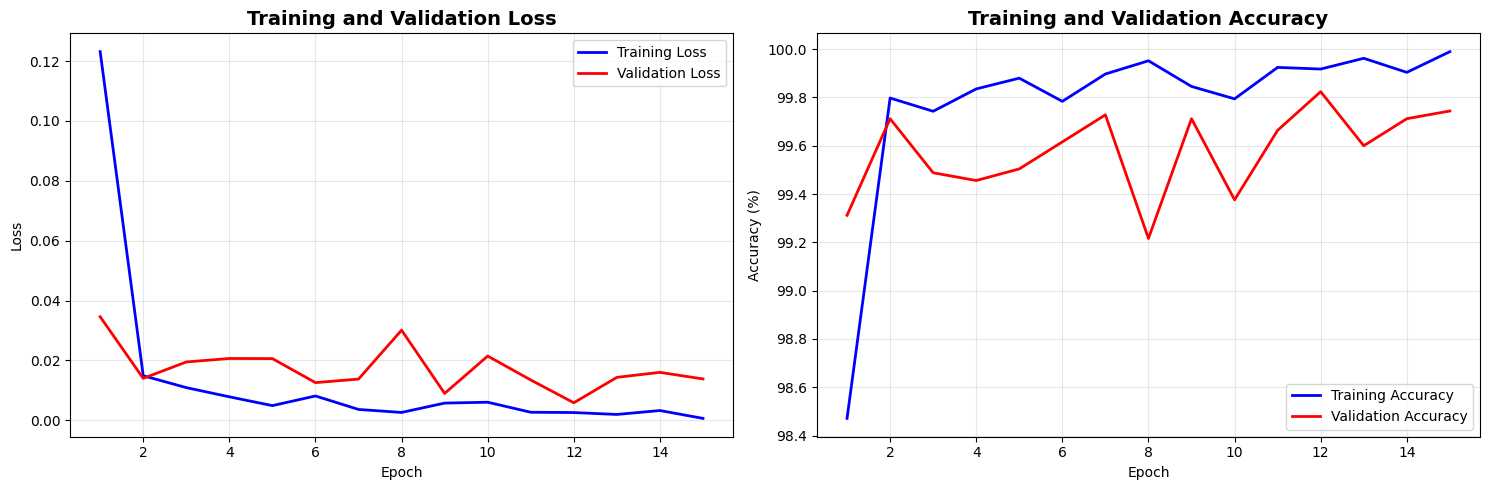


Final Training Statistics:
----------------------------------------
Final Training Loss: 0.0006
Final Training Accuracy: 99.99%
Final Validation Loss: 0.0138
Final Validation Accuracy: 99.74%
Best Validation Accuracy: 99.82%


In [14]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
epochs_range = range(1, NUM_EPOCHS + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracies
ax2.plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print("\nFinal Training Statistics:")
print("-" * 40)
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

In [15]:
def evaluate_model(model, test_loader, device, class_names):
    """Comprehensive model evaluation on test set"""
    model.eval()
    all_predictions = []
    all_labels = []
    correct_predictions = 0
    total_samples = 0
    
    print("Evaluating on test set...")
    
    with torch.no_grad():
        for batch in test_loader:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(pixel_values=pixel_values)
            _, predicted = torch.max(outputs.logits.data, 1)
            
            # Collect predictions and labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Calculate accuracy
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    # Calculate overall accuracy
    test_accuracy = 100.0 * correct_predictions / total_samples
    
    print(f"\nTest Set Results:")
    print("=" * 50)
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Correct Predictions: {correct_predictions}/{total_samples}")
    
    # Classification report
    print(f"\nDetailed Classification Report:")
    print("-" * 50)
    report = classification_report(
        all_labels, 
        all_predictions, 
        target_names=class_names,
        digits=3
    )
    print(report)
    
    return all_predictions, all_labels, test_accuracy

# Evaluate the model
predictions, true_labels, test_acc = evaluate_model(model, test_loader, device, CLASS_NAMES)

Evaluating on test set...

Test Set Results:
Test Accuracy: 99.65%
Correct Predictions: 6231/6253

Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

        bags      0.983     0.960     0.971       300
       shoes      1.000     0.987     0.993       300
      laptop      0.983     0.993     0.988       299
      shirts      0.977     0.997     0.987       300
     watches      1.000     1.000     1.000      3037
     glasses      1.000     1.000     1.000      1717
  headphones      0.983     0.993     0.988       300

    accuracy                          0.996      6253
   macro avg      0.990     0.990     0.990      6253
weighted avg      0.997     0.996     0.996      6253



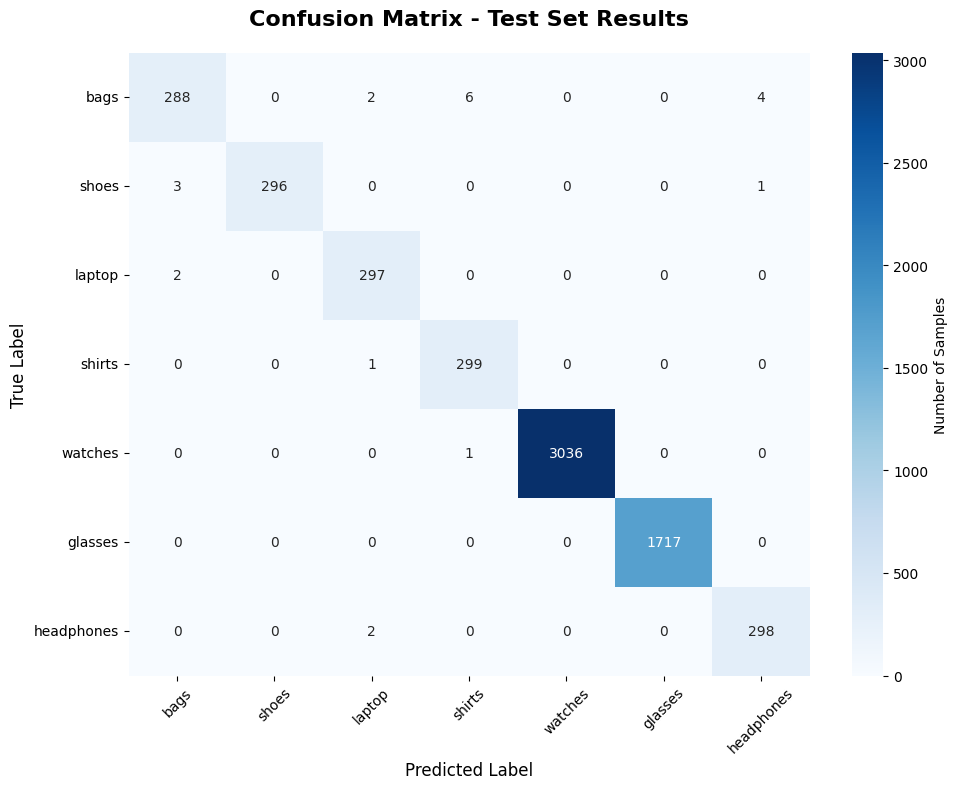


Per-Class Accuracy:
------------------------------
bags        :  96.00% ( 288/ 300)
shoes       :  98.67% ( 296/ 300)
laptop      :  99.33% ( 297/ 299)
shirts      :  99.67% ( 299/ 300)
watches     :  99.97% (3036/3037)
glasses     : 100.00% (1717/1717)
headphones  :  99.33% ( 298/ 300)


In [16]:
# Create and plot confusion matrix
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Number of Samples'})

plt.title('Confusion Matrix - Test Set Results', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\nPer-Class Accuracy:")
print("-" * 30)
for i, class_name in enumerate(CLASS_NAMES):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()    
    class_acc = 100.0 * class_correct / class_total if class_total > 0 else 0
    print(f"{class_name:12}: {class_acc:6.2f}% ({class_correct:4d}/{class_total:4d})")

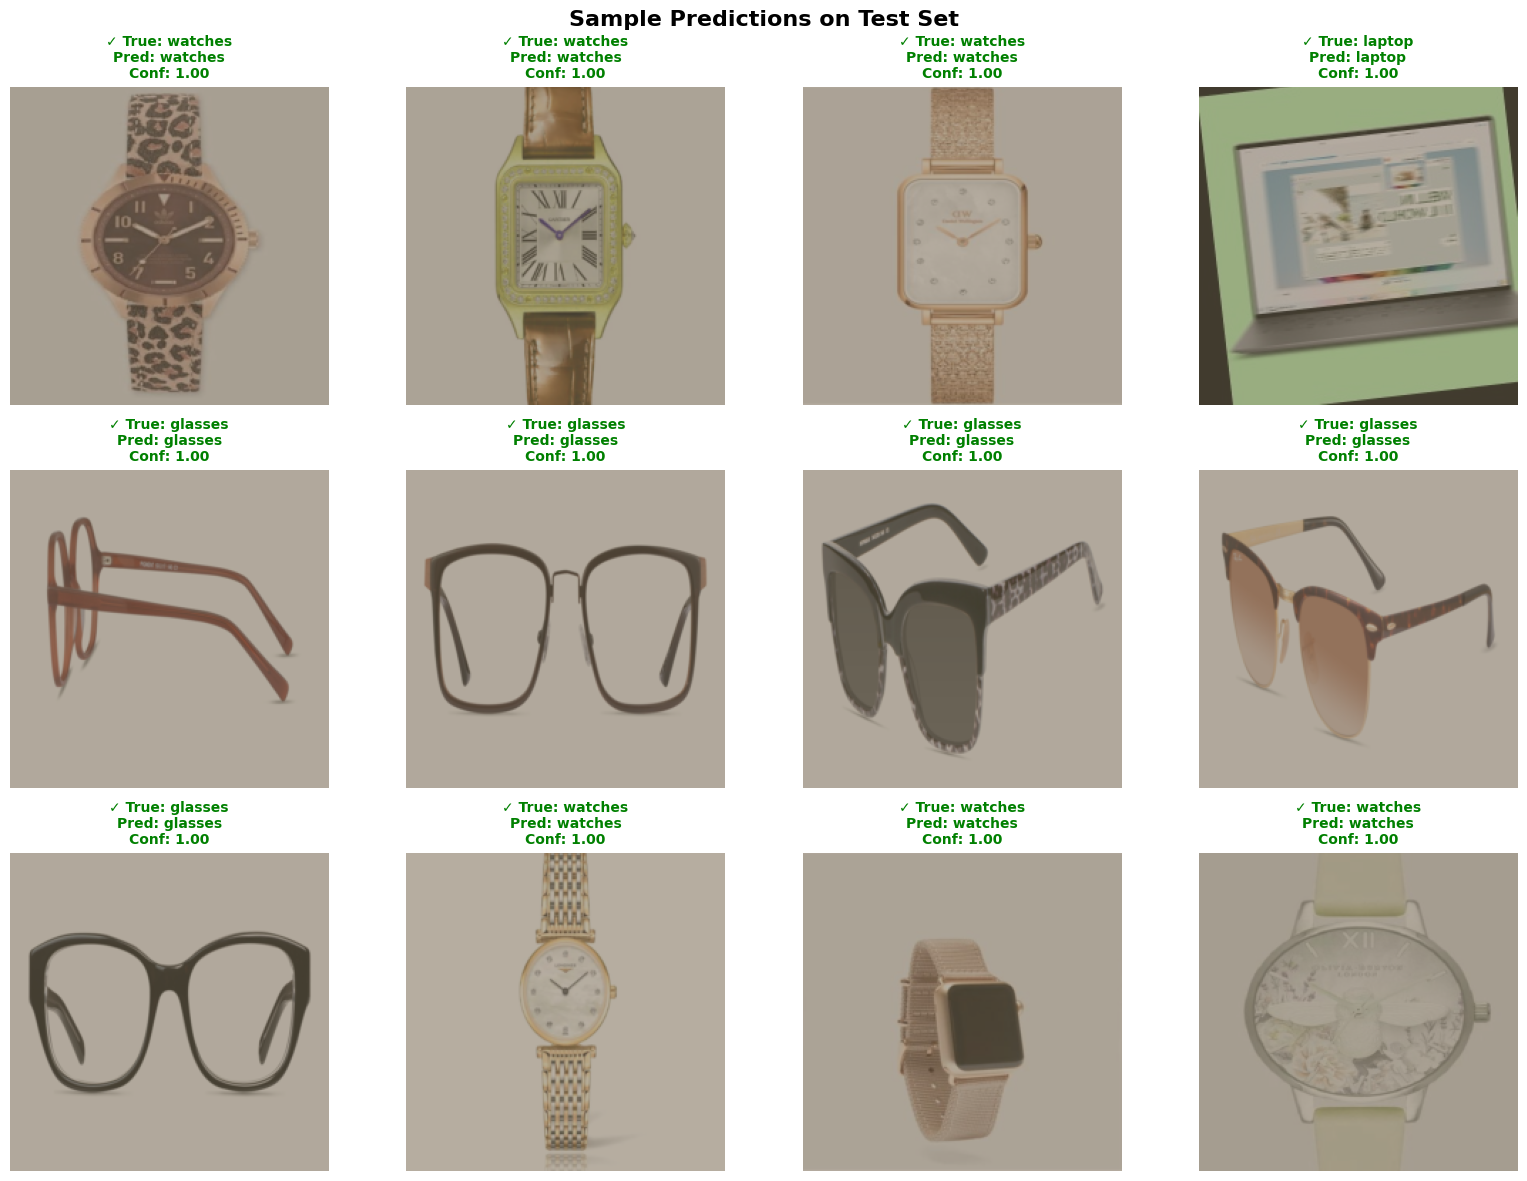

In [17]:
def show_sample_predictions(model, test_dataset, device, class_names, num_samples=12):
    """Show sample predictions with images"""
    model.eval()
    
    # Get random samples
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            sample = test_dataset[idx]
            pixel_values = sample['pixel_values'].unsqueeze(0).to(device)
            true_label = sample['labels'].item()
            
            # Get prediction
            outputs = model(pixel_values=pixel_values)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0, predicted_class].item()
            
            # Prepare image for display
            img = sample['pixel_values'].numpy()
            img = np.transpose(img, (1, 2, 0))
            # Denormalize
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = img * std + mean
            img = np.clip(img, 0, 1)
            
            # Plot
            axes[i].imshow(img)
            axes[i].axis('off')
            
            # Create title with prediction info
            true_class = class_names[true_label]
            pred_class = class_names[predicted_class]
            
            if predicted_class == true_label:
                title_color = 'green'
                title = f'✓ True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}'
            else:
                title_color = 'red'  
                title = f'✗ True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}'
            
            axes[i].set_title(title, color=title_color, fontsize=10, fontweight='bold')
    
    plt.suptitle('Sample Predictions on Test Set', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Show sample predictions
show_sample_predictions(model, test_dataset, device, CLASS_NAMES)

In [19]:
# Final performance summary
print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)

print(f"\n📊 Dataset Information:")
print(f"   • Total Images: {train_total + val_total + test_total:,}")
print(f"   • Training: {train_total:,} images")
print(f"   • Validation: {val_total:,} images") 
print(f"   • Test: {test_total:,} images")
print(f"   • Classes: {NUM_CLASSES} product categories")

print(f"\n🤖 Model Information:")
print(f"   • Architecture: {MODEL_NAME}")
print(f"   • Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   • Input Size: 224x224 pixels")
print(f"   • Batch Size: {BATCH_SIZE}")

print(f"\n🎯 Training Results:")
print(f"   • Epochs Trained: {NUM_EPOCHS}")
print(f"   • Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"   • Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"   • Final Test Accuracy: {test_acc:.2f}%")

# Check for overfitting
train_val_gap = train_accuracies[-1] - val_accuracies[-1]
if train_val_gap > 5:
    print(f"   ⚠️  Potential overfitting detected (Train-Val gap: {train_val_gap:.2f}%)")
else:
    print(f"   ✅ Good generalization (Train-Val gap: {train_val_gap:.2f}%)")

print(f"\n💡 Key Insights:")
# Find best and worst performing classes
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_accuracies = np.diag(cm_norm) * 100

best_class_idx = np.argmax(class_accuracies)
worst_class_idx = np.argmin(class_accuracies)

print(f"   • Best performing class: {CLASS_NAMES[best_class_idx]} ({class_accuracies[best_class_idx]:.1f}%)")
print(f"   • Most challenging class: {CLASS_NAMES[worst_class_idx]} ({class_accuracies[worst_class_idx]:.1f}%)")

# Calculate average confidence for correct predictions
print(f"\n🔧 Recommendations for Improvement:")
if test_acc < 85:
    print(f"   • Consider training for more epochs")
    print(f"   • Try data augmentation techniques")
    print(f"   • Experiment with different learning rates")
if train_val_gap > 10:
    print(f"   • Add regularization (dropout, weight decay)")
    print(f"   • Use data augmentation to reduce overfitting")

print("\n" + "="*60)


FINAL MODEL PERFORMANCE SUMMARY

📊 Dataset Information:
   • Total Images: 41,677
   • Training: 29,172 images
   • Validation: 6,252 images
   • Test: 6,253 images
   • Classes: 7 product categories

🤖 Model Information:
   • Architecture: google/vit-base-patch16-224-in21k
   • Total Parameters: 85,804,039
   • Input Size: 224x224 pixels
   • Batch Size: 64

🎯 Training Results:
   • Epochs Trained: 15
   • Best Validation Accuracy: 99.82%
   • Final Training Accuracy: 99.99%
   • Final Test Accuracy: 99.65%
   ✅ Good generalization (Train-Val gap: 0.25%)

💡 Key Insights:
   • Best performing class: glasses (100.0%)
   • Most challenging class: bags (96.0%)

🔧 Recommendations for Improvement:



In [20]:
# Save the trained model
MODEL_SAVE_PATH = 'product_classifier_vit.pth'

# Save model state dict and additional info
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': CLASS_NAMES,
    'label_to_idx': label_to_idx,
    'idx_to_label': idx_to_label,
    'model_name': MODEL_NAME,
    'test_accuracy': test_acc,
    'training_history': {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }
}, MODEL_SAVE_PATH)

print(f"✅ Model saved successfully to: {MODEL_SAVE_PATH}")
print(f"📁 File size: {os.path.getsize(MODEL_SAVE_PATH) / (1024*1024):.1f} MB")

# Example of how to load the model later
print(f"\n📖 To load this model later, use:")
print(f"""
# Load the saved model
checkpoint = torch.load('{MODEL_SAVE_PATH}')
model = ViTForImageClassification.from_pretrained(
    '{MODEL_NAME}',
    num_labels={NUM_CLASSES},
    ignore_mismatched_sizes=True
)
model.load_state_dict(checkpoint['model_state_dict'])
class_names = checkpoint['class_names']
""")

✅ Model saved successfully to: product_classifier_vit.pth
📁 File size: 327.4 MB

📖 To load this model later, use:

# Load the saved model
checkpoint = torch.load('product_classifier_vit.pth')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=7,
    ignore_mismatched_sizes=True
)
model.load_state_dict(checkpoint['model_state_dict'])
class_names = checkpoint['class_names']

